In [26]:
from tensorflow.python.client import device_lib

print("Available devices:")
for device in device_lib.list_local_devices():
    if device.device_type == "GPU":
        print(f"Name: {device.name}, Type: {device.device_type}, Memory: {device.memory_limit / 1024**3:.2f} GB")

Available devices:
Name: /device:GPU:0, Type: GPU, Memory: 2.08 GB


<h1>Load Dataset</h1>

In [27]:
import tensorflow as tf
from keras import utils, layers
from keras.layers import Dense,Dropout,BatchNormalization
from keras.optimizers import Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import numpy as np

In [28]:
img_height = 224
img_width = 224
num_classes = 3
batch_size = 16

In [29]:
data_train = utils.image_dataset_from_directory(
    'dataset-cleaned/train',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 283 files belonging to 3 classes.


In [30]:
data_val = utils.image_dataset_from_directory(
    'dataset-cleaned/val',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 60 files belonging to 3 classes.


In [31]:
data_test = utils.image_dataset_from_directory(
    'dataset-cleaned/test',
    labels='inferred',
    label_mode='int',
    class_names=['0','1','3'],
    color_mode='rgb',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 64 files belonging to 3 classes.


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train = data_train.cache().prefetch(buffer_size=AUTOTUNE)
val = data_val.cache().prefetch(buffer_size=AUTOTUNE)
test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


<h1>Visualization of Samples</h1>

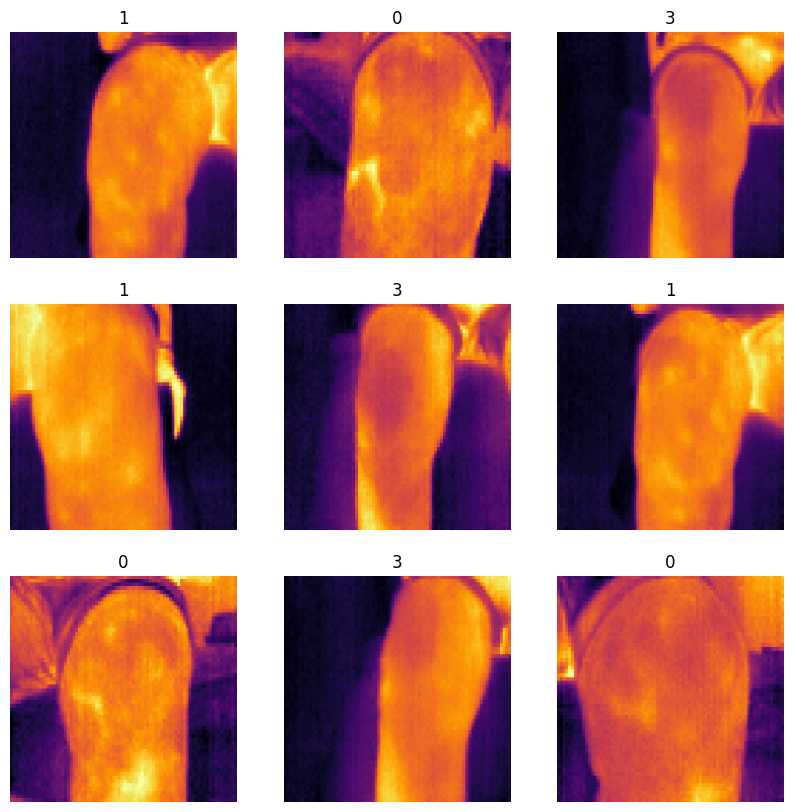

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1): 
  num_images_to_show = 9
  for i in range(num_images_to_show):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_train.class_names[labels[i]])
    plt.axis("off")
plt.show()

<h1>Neural Network Architecture</h1>

In [ ]:
img_shape=(img_height, img_width, 3)
inputs = tf.keras.Input(shape=img_shape)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.GaussianNoise(0.02)
])
x = data_augmentation(inputs)


base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet", pooling='max', input_shape=img_shape)
base_model.trainable=False

x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(9, kernel_regularizer = regularizers.l2(l = 0.0325),activity_regularizer=regularizers.l1(0.0225),
          bias_regularizer=regularizers.l1(0.0225) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)


lr=.0001
outputs=Dense(num_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=outputs)
model.compile(Adamax(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
epochs = 100
history = model.fit(train, validation_data=val, epochs=epochs, verbose=1, callbacks=[early_stopping])

Epoch 1/100
18/18 [==============================] - 4s 71ms/step - loss: 2.0842 - accuracy: 0.3569 - val_loss: 2.1077 - val_accuracy: 0.3000
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 1.9894 - accuracy: 0.3887 - val_loss: 1.9752 - val_accuracy: 0.3333
Epoch 3/100
18/18 [==============================] - 0s 22ms/step - loss: 1.8805 - accuracy: 0.4488 - val_loss: 1.9007 - val_accuracy: 0.3500
Epoch 4/100
18/18 [==============================] - 0s 21ms/step - loss: 1.8231 - accuracy: 0.4488 - val_loss: 1.8524 - val_accuracy: 0.3500
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 1.8181 - accuracy: 0.4735 - val_loss: 1.8174 - val_accuracy: 0.4000
Epoch 6/100
18/18 [==============================] - 0s 22ms/step - loss: 1.7776 - accuracy: 0.4876 - val_loss: 1.7886 - val_accuracy: 0.4000
Epoch 7/100
18/18 [==============================] - 0s 22ms/step - loss: 1.7434 - accuracy: 0.5124 - val_loss: 1.7621 - val_accuracy: 0.4500
Epoch 

In [38]:
loss, accuracy = model.evaluate(test)

4/4 [==============================] - 0s 16ms/step - loss: 0.8377 - accuracy: 0.9688


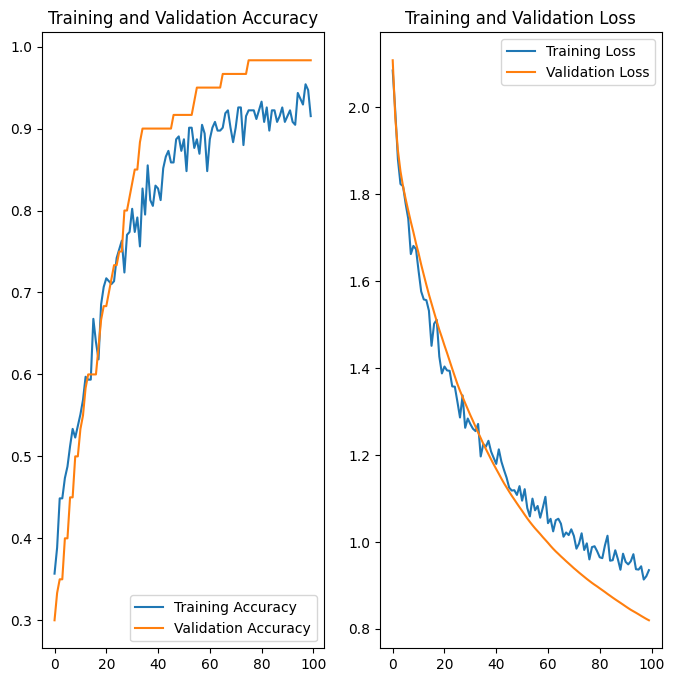

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
tf.saved_model.save(model, "tf-osteo")

INFO:tensorflow:Assets written to: tf-osteo\assets


INFO:tensorflow:Assets written to: tf-osteo\assets
